In [1]:
%matplotlib notebook

import argparse
import torch
import matplotlib.pyplot as plt
from data import NoisyBSDSDataset
from argument import Args
from model import DnCNN, UDnCNN, DUDnCNN
import nntools as nt
from utils import DenoisingStatsManager, plot

In [2]:
args = Args()
args.plot = True

In [5]:
args.root_dir = '../dataset/CBSD68-dataset/CBSD68/'
args.output_dir = '../checkpoints/averaged/dudncnn/d16_bs4_lre5/'
args.D = 16
args.batch_size = 4
args.lr = 1e-5
args.averaged = True
vars(args)

{'root_dir': '../dataset/CBSD68-dataset/CBSD68/',
 'output_dir': '../checkpoints/averaged/dudncnn/d16_bs4_lre5/',
 'num_epochs': 200,
 'D': 16,
 'C': 64,
 'plot': True,
 'model': 'dudncnn',
 'lr': 1e-05,
 'image_size': (180, 180),
 'test_image_size': (320, 320),
 'batch_size': 4,
 'sigma': 30,
 'averaged': True}

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# dataset
train_set = NoisyBSDSDataset(
    args.root_dir, image_size=args.image_size, sigma=args.sigma, averaged=args.averaged)
test_set = NoisyBSDSDataset(
    args.root_dir, mode='test', image_size=args.test_image_size, sigma=args.sigma, averaged=args.averaged)

# model
if args.model == 'dncnn':
    net = DnCNN(args.D, C=args.C).to(device)
elif args.model == 'udncnn':
    net = UDnCNN(args.D, C=args.C).to(device)
elif args.model == 'dudncnn':
    net = DUDnCNN(args.D, C=args.C).to(device)
else:
    raise NameError('Please enter: dncnn, udncnn, or dudncnn')

# optimizer
adam = torch.optim.Adam(net.parameters(), lr=args.lr)

# stats manager
stats_manager = DenoisingStatsManager()

# experiment
exp = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=args.batch_size,
                    output_dir=args.output_dir, perform_validation_during_training=True)

cpu


In [ ]:
# run
if args.plot:
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
    exp.run(num_epochs=args.num_epochs, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))
else:
    exp.run(num_epochs=args.num_epochs)

## Testing on other image

In [8]:
from PIL import Image
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [10]:
def image_preprocess(img_path):
    img = Image.open(img_path).convert('RGB')  
    transform = tv.transforms.Compose([
        tv.transforms.Resize(300),
        # convert it to a tensor
        tv.transforms.ToTensor(),
        # normalize it to the range [−1, 1]
        tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    img = transform(img)
    return img

In [11]:
model = exp.net.to(device)
titles = ['origin', 'denoise']
img_path = "../images/noisyOCT.jpeg"
x = image_preprocess(img_path=img_path)
img = []
img.append(x)
x = x.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])

<IPython.core.display.Javascript object>


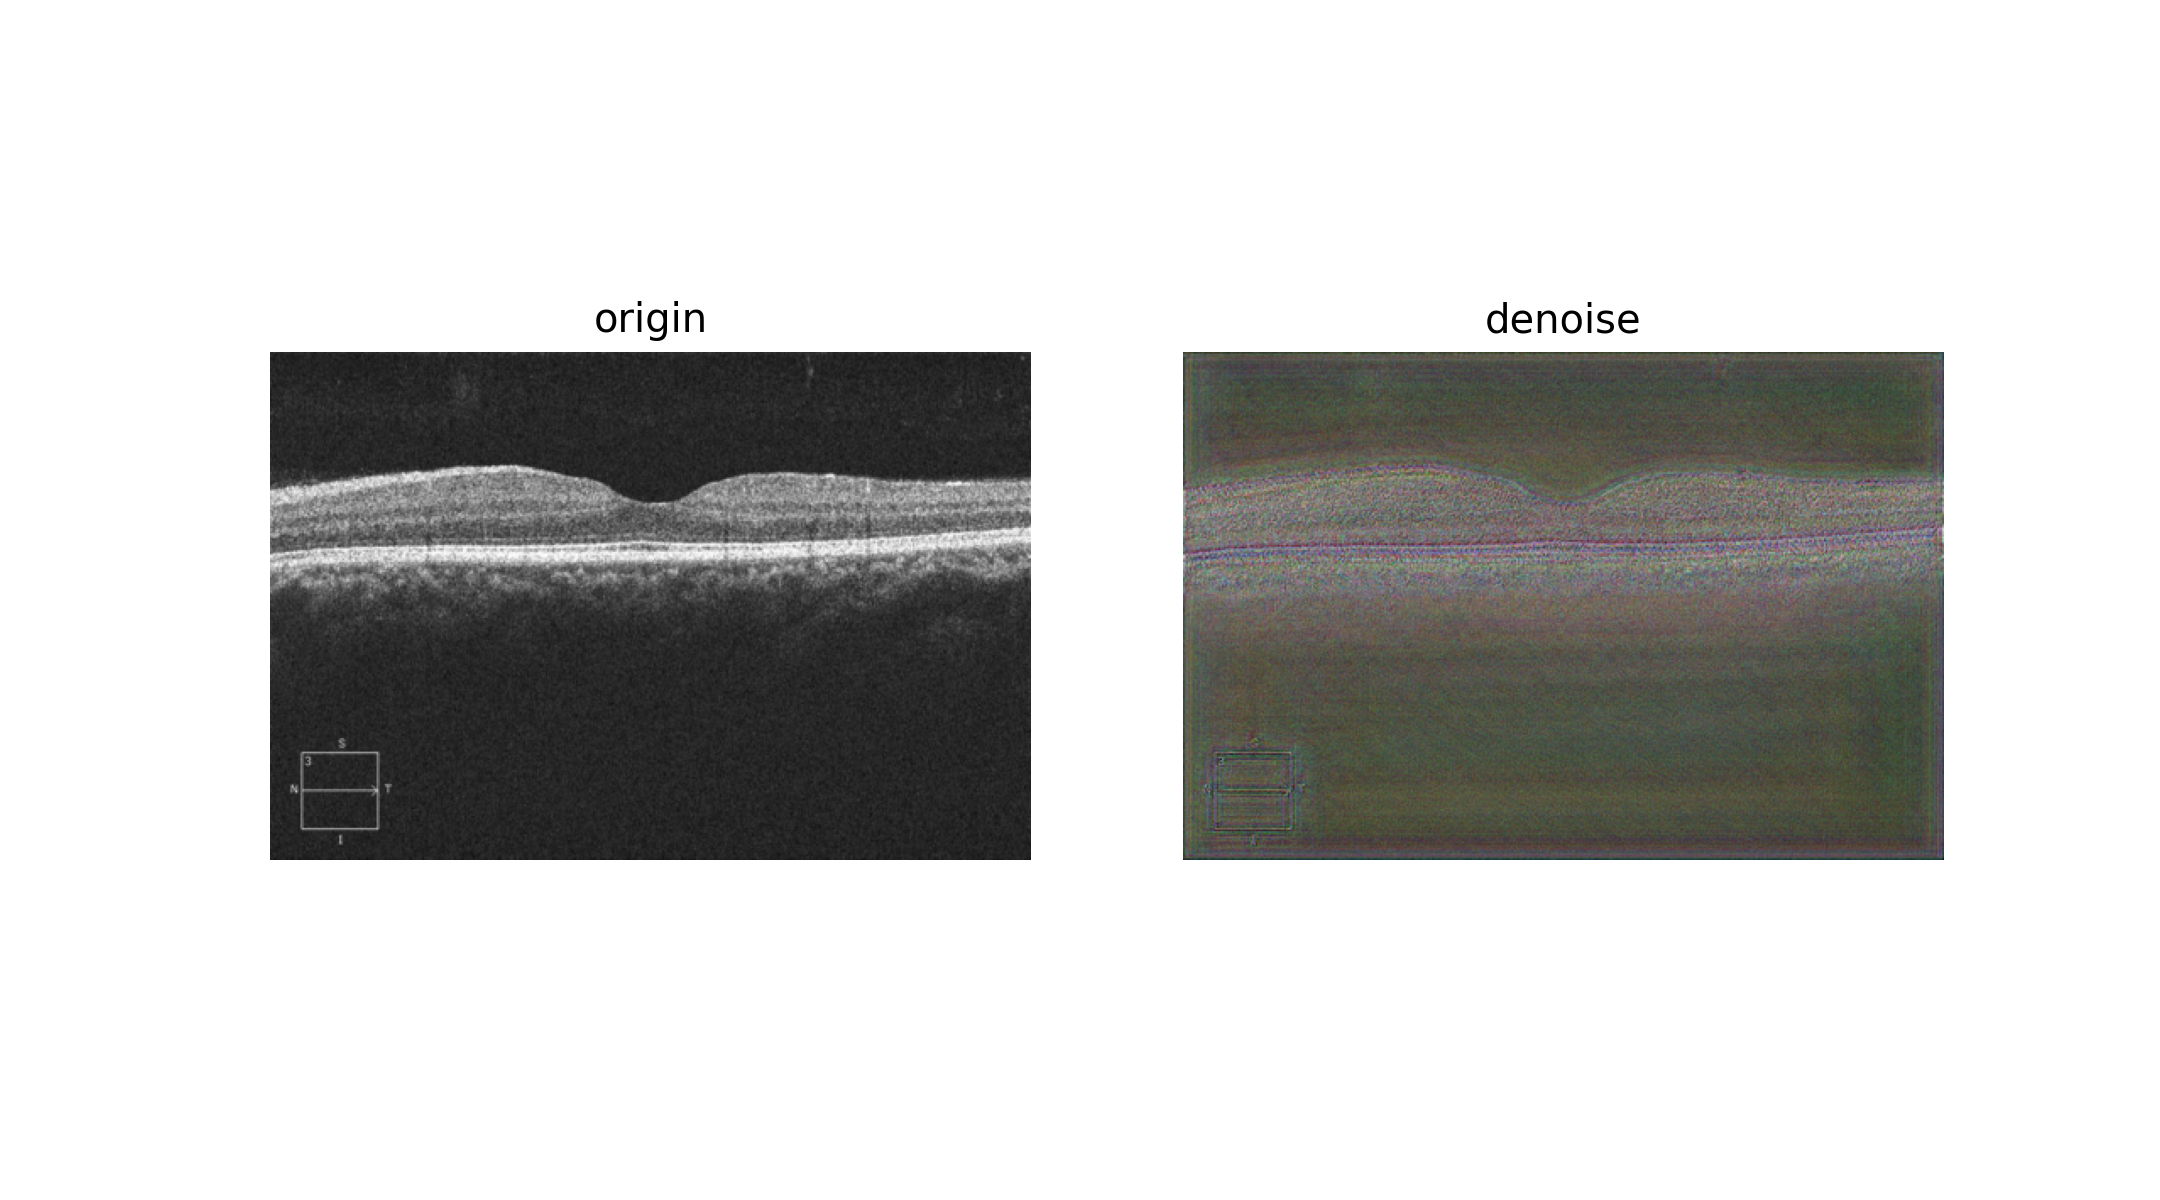

In [12]:
fig, axes = plt.subplots(ncols=len(img), figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')